# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise Estatística Para Data Science com Linguagem Python</font>
## <font color='blue'>Mini-Projeto 6</font>
### <font color='blue'>Análise Estatística Inferencial em Marketing Digital Para Prever o Comportamento do Consumidor</font>

In [60]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.18


## Instalando e Carregando os Pacotes

In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [ ]:
!pip install -q tensorflow==2.15

In [61]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [62]:
# Imports

# Imports para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns

# Imports para pré-processamento e avaliação
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Imports para Deep Learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Nadam

In [63]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

sklearn   : 1.3.2
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.0.3
matplotlib: 3.8.2
keras     : 2.15.0
tensorflow: 2.15.0



## Carregando os Dados

In [64]:
# Carrega o dataset
dataset = pd.read_csv("dados/hotel_bookings.csv")

In [65]:
# Shape
dataset.shape

(119390, 32)

In [66]:
# Visualiza os dados
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


**Vamos usar Inteligência Artificial, especificamente Deep Learning, para prever o cancelamento de reservas em hotéis.**

## Análise Exploratória

In [67]:
# Número de colunas
print(len(dataset.columns))

32


In [68]:
# Tipos de dados
dataset.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [69]:
# Vamos checar quais colunas são do tipo string
for column, series in dataset.items():
    if str(type(series[0])) == "<class 'str'>":
        print(column)

hotel
arrival_date_month
meal
country
market_segment
distribution_channel
reserved_room_type
assigned_room_type
deposit_type
customer_type
reservation_status
reservation_status_date


Não podemos levar valores no formato de texto para o treinamento do modelo. Vamos tratar isso daqui a pouco. Primeiro vamos checar se temos valores ausentes.

In [70]:
# Total de valores ausentes por coluna
dataset.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Sim, temos em algumas colunas. Então vamos ao processo de limpeza e transformação dos dados.

## Limpeza e Transformação

A coluna company tem quase todos os registros nulos e não faz sentido manter essa coluna. Vamos removê-la.

In [71]:
# Remove a coluna "company"
dataset = dataset.drop(['company'], axis = 1)

Temos ainda duas colunas com valores nulos e diversas estratégias poderiam ser adotadas. Valores ausentes não podem ser deixados no dataset.

Para os valores ausentes na coluna "country", vamos apenas remover a coluna. Para a coluna "agent", removeremos todas as linhas onde esta coluna for valor ausente.

Você pode testar outras abordagens se desejar.

In [72]:
# Remove a coluna "country"
dataset = dataset.drop(['country'], axis = 1)

In [73]:
# Removemos valores ausentes que ainda estverem no dataset
dataset = dataset.dropna()

In [74]:
# Shape
dataset.shape

(103048, 30)

In [75]:
# Total de valores ausentes por coluna
dataset.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

Agora vamos trabalhar em outras variáveis. Temos muitas variáveis categóricas nesse dataset e teremos que tomar algumas ações. 

Uma alternativa simples é aplicar o Label Encoding, ou seja, convertemos o texto em cada coluna para um valor numérico correspondente. Vamos ao trabalho.

**Encoding da variável com o mês de chegada no hotel.**

In [76]:
# Valores únicos para a coluna de mês de chegada
dataset.arrival_date_month.unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [77]:
# Dicionário de meses
mes_dict = {"January": 1,
            "February": 2,
            "March": 3,
            "April": 4,
            "May": 5,
            "June": 6,
            "July": 7,
            "August": 8,
            "September": 9,
            "October": 10,
            "November": 11,
            "December": 12}

In [78]:
# Vamos converter os meses para o valor numérico correspondente, conforme colocamos no dicionário
dataset['arrival_date_month_numerical'] = dataset.arrival_date_month.apply(lambda x: mes_dict[x])

In [79]:
# Total de registros para cada mês
dataset.arrival_date_month_numerical.value_counts()

arrival_date_month_numerical
8     12680
7     11604
5     10089
6      9806
4      9758
10     9461
9      9437
3      8149
2      6461
12     5631
11     5409
1      4563
Name: count, dtype: int64

Mês de Agosto teve o maior número de reservas e mês de Janeiro o menor. Isso se explica porque no hemisfério Norte o auge do Verão e as férias são em Agosto.

In [80]:
# Não precisamos mais da coluna "arrival_date_month"
dataset = dataset.drop("arrival_date_month", axis = 1)

**Encoding das variáveis com tipo de quarto reservado e tipo de quarto ocupado.**

In [81]:
# Valores únicos de quartos reservados
dataset.reserved_room_type.unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'H', 'B'], dtype=object)

In [82]:
# Valores únicos de quartos já ocupados
dataset.assigned_room_type.unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'K'], dtype=object)

Vamos adotar a mesma estratégia usada com os meses.

In [83]:
# Dicionário para o encoding do tipo de quarto
tipo_quarto_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8, "I": 9, "K": 11, "L": 12, "P": 15}

In [84]:
# Atribuímos o dicionário para fazer o encoding nas colunas com texto e criar as colunas numéricas
dataset["reserved_room_type_numerical"] = dataset.reserved_room_type.apply(lambda x: tipo_quarto_dict[x])
dataset["assigned_room_type_numerical"] = dataset.assigned_room_type.apply(lambda x: tipo_quarto_dict[x])

In [85]:
# Visualiza os dados
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical
3,Resort Hotel,0,13,2015,27,1,0,1,1,0.0,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,1,1
4,Resort Hotel,0,14,2015,27,1,0,2,2,0.0,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,1,1
5,Resort Hotel,0,14,2015,27,1,0,2,2,0.0,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,1,1
7,Resort Hotel,0,9,2015,27,1,0,2,2,0.0,...,0,Transient,103.0,0,1,Check-Out,2015-07-03,7,3,3
8,Resort Hotel,1,85,2015,27,1,0,3,2,0.0,...,0,Transient,82.0,0,1,Canceled,2015-05-06,7,1,1


Removemos as duas colunas com valores em texto.

In [86]:
# Não precisamos mais das colunas "reserved_room_type" e "assigned_room_type"
dataset = dataset.drop(["reserved_room_type", "assigned_room_type"], axis = 1)

**Encoding da variável com o tipo de depósito.**

In [87]:
# Valores únicos da variável "deposit_type"
dataset.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [88]:
# Dicionário
deposit_type_dict = {"No Deposit":0, "Refundable": 1, "Non Refund": -1}

In [89]:
# Aplicamos o encoding
dataset["deposit_type_numerical"] = dataset.deposit_type.apply(lambda x: deposit_type_dict[x])

In [90]:
# Drop da coluna "deposit_type"
dataset = dataset.drop("deposit_type", axis = 1)

**Encoding da variável com o tipo de cliente.**

In [91]:
# Valores únicos
dataset.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [93]:
# Dicionário
customer_type_dict = {'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3}

In [94]:
# Aplicamos o encoding
dataset["customer_type_numericar"] = dataset.customer_type.apply(lambda x: customer_type_dict[x])

In [95]:
# Drop da coluna "customer_type"
dataset = dataset.drop("customer_type", axis = 1)

**Encoding da variável com o tipo de hotel.**

In [96]:
# Valores únicos
dataset.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [97]:
# Dicionário com o tipo de hotel
hotel_dict = {'Resort Hotel': 0, 'City Hotel':1}

In [98]:
# Aplica o encoding e cria nova coluna
dataset["hotel_numerical"] = dataset.hotel.apply(lambda x: hotel_dict[x])

In [99]:
# Drop da coluna "hotel"
dataset = dataset.drop('hotel', axis = 1)

**Encoding da variável com o tipo de refeição.**

In [100]:
# Valores únicos
dataset.meal.unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [101]:
# Dicionário 
meal_dict = {'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': -1}

In [102]:
# Aplica o encoding e cria nova coluna
dataset["meal_numerical"] = dataset.meal.apply(lambda x: meal_dict[x])

In [104]:
# Drop da coluna "meal"
dataset = dataset.drop('meal', axis = 1)

KeyError: "['meal'] not found in axis"

**Encoding da variável com o tipo de segmento de mercado.**

In [105]:
# Valores únicos
dataset.market_segment.unique()

array(['Corporate', 'Online TA', 'Direct', 'Offline TA/TO', 'Groups',
       'Complementary', 'Aviation'], dtype=object)

In [107]:
# Dicionário
market_segment_dict = {'Corporate': 0, 
                       'Online TA': 1, 
                       'Direct': 2, 
                       'Offline TA/TO': 3, 
                       'Groups':4,
                       'Complementary': 5, 
                       'Aviation': 6,
                       'GDS': 7,
                       'TA/TO': 8,
                       'Undefined': -1}

In [108]:
# Aplica o encoding
dataset["market_segment_numerical"] = dataset.market_segment.apply(lambda x: market_segment_dict[x])
dataset["distribution_channel_numerical"] = dataset.distribution_channel.apply(lambda x: market_segment_dict[x])

In [109]:
# Não precisamos mais das colunas "market_segment" e "distribution_channel"
dataset = dataset.drop(['market_segment','distribution_channel'], axis = 1)

In [111]:
# Visualiza os dados
dataset.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reservation_status_date,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical,deposit_type_numerical,customer_type_numericar,hotel_numerical,meal_numerical,market_segment_numerical,distribution_channel_numerical
3,0,13,2015,27,1,0,1,1,0.0,0,...,2015-07-02,7,1,1,0,0,0,0,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,2015-07-03,7,1,1,0,0,0,0,1,8
5,0,14,2015,27,1,0,2,2,0.0,0,...,2015-07-03,7,1,1,0,0,0,0,1,8
7,0,9,2015,27,1,0,2,2,0.0,0,...,2015-07-03,7,3,3,0,0,0,1,2,2
8,1,85,2015,27,1,0,3,2,0.0,0,...,2015-05-06,7,1,1,0,0,0,0,1,8


In [112]:
# Tipos de dados
dataset.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
reservation_status                 object
reservation_status_date            object
arrival_date_month_numerical        int64
reserved_room_type_numerical        int64
assigned_room_type_numerical      

Temos ainda 2 variáveis do tipo object, ou seja, string. Como as duas variáveis contém status de reserva e data, vamos apenas removê-las.

In [113]:
# Valores únicos
dataset.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [114]:
# Drop
dataset = dataset.drop("reservation_status", axis = 1)

In [115]:
# Valores únicos
dataset.reservation_status_date.unique()

array(['2015-07-02', '2015-07-03', '2015-05-06', '2015-04-22',
       '2015-06-23', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-01', '2015-07-08', '2015-05-11', '2015-07-16',
       '2015-05-19', '2015-06-19', '2015-05-23', '2015-05-18',
       '2015-07-09', '2015-06-02', '2015-07-13', '2015-07-04',
       '2015-06-29', '2015-06-16', '2015-06-18', '2015-06-12',
       '2015-06-09', '2015-05-26', '2015-07-11', '2015-07-12',
       '2015-07-17', '2015-04-15', '2015-05-13', '2015-07-10',
       '2015-05-20', '2015-05-12', '2015-07-14', '2015-05-29',
       '2015-06-17', '2015-05-01', '2015-03-30', '2015-07-15',
       '2015-07-19', '2015-06-03', '2015-06-26', '2015-05-14',
       '2015-07-20', '2015-05-07', '2015-05-28', '2015-04-13',
       '2015-03-25', '2015-07-21', '2015-06-27', '2015-07-18',
       '2015-07-23', '2015-06-08', '2015-06-22', '2015-06-24',
       '2015-03-05', '2015-06-01', '2015-04-24', '2015-07-22',
       '2015-05-27', '2015-04-06', '2015-04-11', '2015-

In [116]:
# Drop
dataset = dataset.drop("reservation_status_date", axis = 1)

In [117]:
# Visualiza os dados
dataset.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,total_of_special_requests,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical,deposit_type_numerical,customer_type_numericar,hotel_numerical,meal_numerical,market_segment_numerical,distribution_channel_numerical
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,7,1,1,0,0,0,0,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,1,7,1,1,0,0,0,0,1,8
5,0,14,2015,27,1,0,2,2,0.0,0,...,1,7,1,1,0,0,0,0,1,8
7,0,9,2015,27,1,0,2,2,0.0,0,...,1,7,3,3,0,0,0,1,2,2
8,1,85,2015,27,1,0,3,2,0.0,0,...,1,7,1,1,0,0,0,0,1,8


In [118]:
# Tipos de dados
dataset.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
arrival_date_month_numerical        int64
reserved_room_type_numerical        int64
assigned_room_type_numerical        int64
deposit_type_numerical              int64
customer_type_numericar           

In [119]:
# Resumo estatístico
dataset.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,total_of_special_requests,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical,deposit_type_numerical,customer_type_numericar,hotel_numerical,meal_numerical,market_segment_numerical,distribution_channel_numerical
count,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,...,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000
mean,0.390032,111.674336,2016.156510,27.339327,15.784198,0.977874,2.589337,1.899464,0.111142,0.007686,...,0.605368,6.594276,2.012392,2.302500,-0.121186,0.453604,0.690911,0.560011,1.980931,7.501368
std,0.487759,107.671506,0.706216,13.285300,8.794013,1.003935,1.905763,0.491057,0.411817,0.097017,...,0.799222,3.020425,1.702388,1.867802,0.327769,0.822159,0.462120,1.060637,1.193171,1.705869
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,26.000000,2016.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000
50%,0.000000,79.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,8.000000
75%,1.000000,169.000000,2017.000000,38.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,1.000000,9.000000,4.000000,4.000000,0.000000,0.000000,1.000000,0.000000,3.000000,8.000000
max,1.000000,629.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,26.000000,10.000000,10.000000,...,5.000000,12.000000,8.000000,11.000000,1.000000,3.000000,1.000000,3.000000,6.000000,8.000000


Limpeza concluída, podemos preparar os dados para treinamento. Vamos seguir para o pré-processamento dos dados.

## Pré-Processamento dos Dados

Primeiro separamos o dataset em X e y.

In [120]:
# Preparamos os dados de entrada em x
X = dataset.drop(["is_canceled"], axis = 1)

In [121]:
# Preparamos a variável de saída y
y = dataset["is_canceled"]

In [122]:
# Convertemos para o tipo categórico
y = to_categorical(y, num_classes = None)

Dividimos os dados em treino e teste, com proporção 80/20.

In [123]:
# Divisão em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, shuffle = True, test_size = 0.2, random_state = 420)

In [126]:
# Shape
print("Shape de X_treino", X_treino.shape)
print("Shape de y_treino", y_treino.shape)
print("Shape de X_teste", X_teste.shape)
print("Shape de y_teste", y_teste.shape)

Shape de X_treino (82438, 27)
Shape de y_treino (82438, 2)
Shape de X_teste (20610, 27)
Shape de y_teste (20610, 2)


In [125]:
X_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82438 entries, 14959 to 13044
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       82438 non-null  int64  
 1   arrival_date_year               82438 non-null  int64  
 2   arrival_date_week_number        82438 non-null  int64  
 3   arrival_date_day_of_month       82438 non-null  int64  
 4   stays_in_weekend_nights         82438 non-null  int64  
 5   stays_in_week_nights            82438 non-null  int64  
 6   adults                          82438 non-null  int64  
 7   children                        82438 non-null  float64
 8   babies                          82438 non-null  int64  
 9   is_repeated_guest               82438 non-null  int64  
 10  previous_cancellations          82438 non-null  int64  
 11  previous_bookings_not_canceled  82438 non-null  int64  
 12  booking_changes                 8

Como as variáveis estão em escala diferente, vamos padronizar e deixar tudo na mesma escala. Fazemos isso somente com X.

In [127]:
# Criamos o objeto scaler
scaler = MinMaxScaler()

In [128]:
# Treinamos e Aplicamos o scaler aos dados de entrada de treino
X_treino = scaler.fit_transform(X_treino)

In [129]:
# Aplicamos o scaler aos dados de entrada de teste
X_teste = scaler.transform(X_teste)

In [130]:
# Resumo
print(f"Matriz da Variável de Entrada:\t{X.shape}\nMatriz da Variável de Saída:\t{y.shape}")

Matriz da Variável de Entrada:	(103048, 27)
Matriz da Variável de Saída:	(103048, 2)


## Construção do Modelo

Vamos criar o modelo de Deep Learning com 5 camadas densas, camadas de dropout para evitar o overfitting e ativação softmax para a classificação.

In [131]:
X.shape

(103048, 27)

In [132]:
# Criamos o modelo
modelo = Sequential()
modelo.add(Dense(200, input_dim = X.shape[1], activation = 'relu'))
modelo.add(Dropout(0.1))
modelo.add(Dense(200, activation = 'relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(200, activation = 'relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(100, activation = 'relu'))
modelo.add(Dropout(0.1))
modelo.add(Dense(2, activation = 'softmax'))

In [133]:
# Usaremos como otimizador o algoritmo Nadam pois o conjunto de dados é complexo
# https://keras.io/api/optimizers/Nadam/
otmizador = tf.keras.optimizers.legacy.Nadam(learning_rate = 0.0001,
                                             beta_1 = 0.9,
                                             beta_2 = 0.999,
                                             epsilon = 1e-07)

In [134]:
# Compilamos o modelo
modelo.compile(optimizer = otmizador, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [135]:
# Vamos criar 2 callbacks
# Um para finalizar o treinamento se depois de 20 passadas o erro não mudar
# Outro para reduzir a taxa de aprendizagem se o erro não mudar após 5 passadas
callbacks = [EarlyStopping(monitor = "loss", patience = 20),
             ReduceLROnPlateau(monitor = "loss", patience = 5)]

In [136]:
# Hiperparâmetros
num_epochs = 50
batch_size = 32

> Treinamento do Modelo.

In [137]:
%%time

print("\nTreinamento Iniciado.\n")

history = modelo.fit(X_treino,
                     y_treino,
                     epochs = num_epochs,
                     batch_size = batch_size,
                     callbacks = callbacks)

print("\nTreinamento Concluído.\n")


Treinamento Iniciado.

Epoch 1/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4960 - accuracy: 0.7526 - lr: 1.0000e-04
Epoch 2/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4430 - accuracy: 0.7833 - lr: 1.0000e-04
Epoch 3/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4284 - accuracy: 0.7918 - lr: 1.0000e-04
Epoch 4/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4210 - accuracy: 0.7960 - lr: 1.0000e-04
Epoch 5/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4135 - accuracy: 0.7999 - lr: 1.0000e-04
Epoch 6/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4073 - accuracy: 0.8041 - lr: 1.0000e-04
Epoch 7/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.4027 - accuracy: 0.8076 - lr: 1.0000e-04
Epoch 8/50
2577/2577 [==============================] - 3s 1ms/step - loss: 0.3981 - accuracy: 0.8099 - lr: 1.0000e-04
Epoch 9/50
2577/2577 [==

## Avaliação do Modelo

O treinamento ocorreu com sucesso. Vamos agora avaliar o modelo.

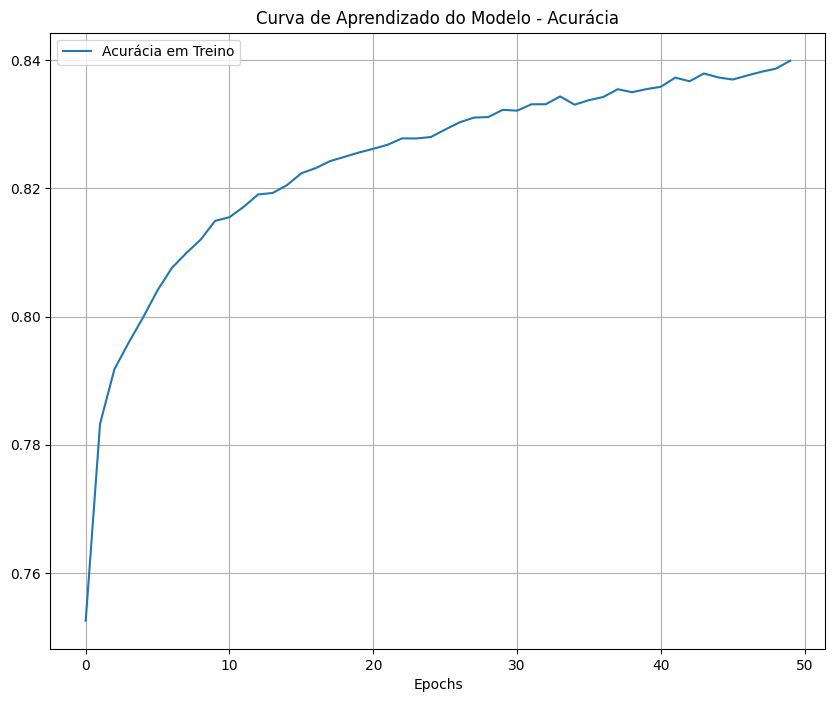

In [138]:
# Plot da Acurácia em Treino
plt.figure(figsize = [10,8])
plt.title("Curva de Aprendizado do Modelo - Acurácia")
plt.plot(history.history['accuracy'], label = 'Acurácia em Treino')
plt.xlabel("Epochs")
plt.legend()
plt.grid()

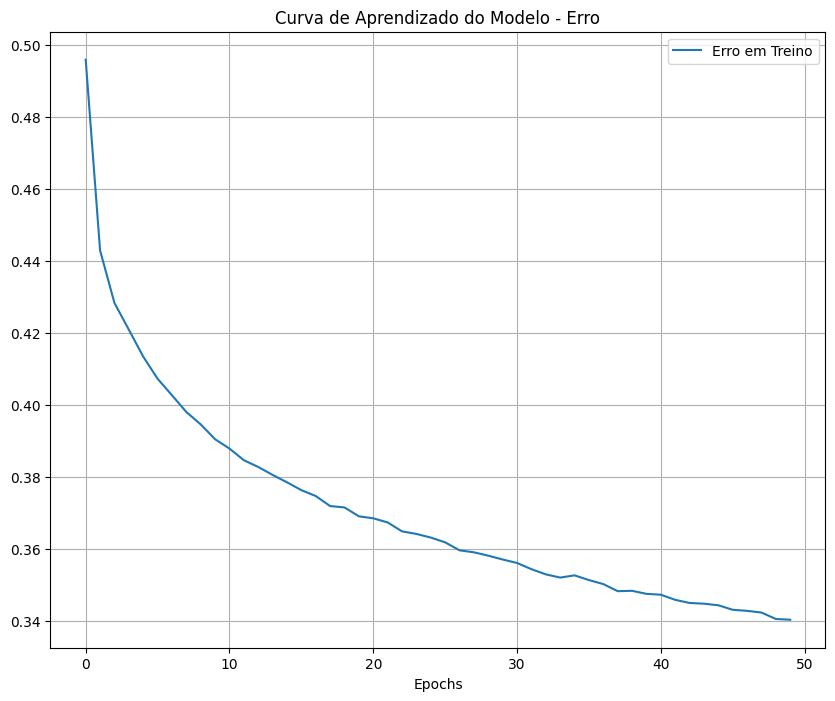

In [139]:
# Plot do Erro em Treino
plt.figure(figsize = [10,8])
plt.title("Curva de Aprendizado do Modelo - Erro")
plt.plot(history.history['loss'], label = 'Erro em Treino')
plt.xlabel("Epochs")
plt.legend()
plt.grid()

## Fazendo Inferência com o Modelo

In [140]:
# Fazemos as previsões com os dados de teste
previsoes = modelo.predict(X_teste)

645/645 [==============================] - 0s 433us/step


In [141]:
# Convertemos as previsões em previsões de classe
y_pred = (previsoes > 0.5)

In [142]:
# Calculamos a acurácia comparando valor real com valor previsto
accuracy_score(y_teste, y_pred)

0.8365841824357109

Nosso modelo tem uma performance de 84%. Um bom trabalho. Mas talvez alguns ajustes possam ser feitos no modelo para melhorar essa performance. Deixaremos isso com você.

In [143]:
# Salva o modelo
modelo.save("modelo/modelo_f.keras")

# Fim